In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import enum
import copy
import connect4.connect4 as game
from pympler import asizeof
import deeplearning.buffer as buf
import torch 
import torch.nn as nn
import torch.optim as optim
import deeplearning.mlp as mlp
import torch.nn.functional as F
import picture_maker

In [120]:
env = game.Connect4()
randomPlayer1 = game.RandomPlayer()
greedyPlayer2 = game.GreedyRandomPlayer()
detPlayer3 = game.DetPlayer()
smartPlayer4 = game.SmartPlayer()
buffer = buf.ReplayBuffer(20000)

In [121]:
gm = game.GameManager([detPlayer3, smartPlayer4])
gm.play(10000, game.Connect4, buffer)
gm.info()

gm = game.GameManager([detPlayer3, greedyPlayer2])
gm.play(5000, game.Connect4, buffer)
gm.info()

gm = game.GameManager([detPlayer3, randomPlayer1])
gm.play(5000, game.Connect4, buffer)
gm.info()

p1:  1.0 p2:  0.0 draw:  0.0
p1:  0.8214 p2:  0.1786 draw:  0.0
p1:  0.8314 p2:  0.1682 draw:  0.0004


In [122]:
randomPlayer1.elo, smartPlayer4.elo, greedyPlayer2.elo, detPlayer3.elo

(999.0, 500.0, 1113.0, 1388.0)

In [224]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

bf = mlp.BF(42, 7, 5000, 1, device).to(device)
optimizer = optim.Adam(params=bf.parameters(), lr=1e-2)

In [225]:
def train_behavior_function(batch_size, model, optimizer):
    """
    Trains the BF with on a cross entropy loss were the inputs are the action probabilities based on the state and command.
    The targets are the actions appropriate to the states from the replay buffer.
    """
    X, y = buffer.create_training_examples(batch_size)


    X = torch.stack(X)


    state = X[:,0:42]
    d = X[:,42:42+1]
    e = X[:,43:43+1]
    command = torch.cat([d, e], dim=-1)
    y = torch.FloatTensor((y)).to(device).long()
    y_ = model(state.to(device), command.to(device)).float()
    optimizer.zero_grad()
    pred_loss = F.cross_entropy(y_, y)   
    pred_loss.backward()
    optimizer.step()
    return pred_loss.detach().cpu().numpy()

def run_loop():
    i = 0
    cum_loss = 0
    best_loss = 100
    best_loss_i = 0
    while True:
        i += 1
        loss = train_behavior_function(10000, bf, optimizer)
        if loss < best_loss - 0.01:
            best_loss = loss
            best_loss_i = i
        if i - best_loss_i > 200:
            print("early stopping")
            return
        cum_loss += loss
        if i % 100 == 0:
            print(i, cum_loss, best_loss_i, best_loss)
            cum_loss = 0
run_loop()

100 75.0293739438057 75 0.46760863
200 47.61858707666397 172 0.3764539
300 45.307280510663986 172 0.3764539
early stopping


In [226]:
with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, greedyPlayer2])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, detPlayer3])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, randomPlayer1])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, smartPlayer4])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, bf2])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

#p1:  0.708 p2:  0.291 draw:  0.001
# p1:  0.262 p2:  0.737 draw:  0.001
# p1:  0.761 p2:  0.239 draw:  0.0
# p1:  0.484 p2:  0.516 draw:  0.0

p1:  0.819 p2:  0.181 draw:  0.0
p1:  0.751 p2:  0.249 draw:  0.0
p1:  0.831 p2:  0.169 draw:  0.0
p1:  1.0 p2:  0.0 draw:  0.0
p1:  0.812 p2:  0.188 draw:  0.0


In [790]:
with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, detPlayer3])
    gm.play(1000, game.Connect4, buf2, 1060)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

p1:  0.5 p2:  0.5 draw:  0.0


In [791]:
def viewer(a):
    print("https://connect4.gamesolver.org/en/?pos=" + "".join([str(x+1) for x in a]))

In [794]:
[viewer(buf2.buffer[1000-1-i]['actions']) for i in range(5)]
[buf2.buffer[1000-1-i]['elo'] for i in range(5)]

https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343


[[1052.0, 1055.0],
 [1052.0, 1055.0],
 [1052.0, 1055.0],
 [1052.0, 1055.0],
 [1052.0, 1055.0]]

In [117]:
bf2 = mlp.BF.load("model")

In [68]:
a = bf.steps([s.flatten()], 1, 1187/1000)[0]
b = bf.steps([s.flatten()], -1, 1187/1000)[0]
a, b

(array([0.08035676, 0.09584816, 0.1062221 , 0.42720458, 0.10776652,
        0.09427083, 0.08833109], dtype=float32),
 array([0.16803548, 0.14177169, 0.1329591 , 0.11727264, 0.13467576,
        0.14903212, 0.15625319], dtype=float32))

In [261]:
s = env.reset()

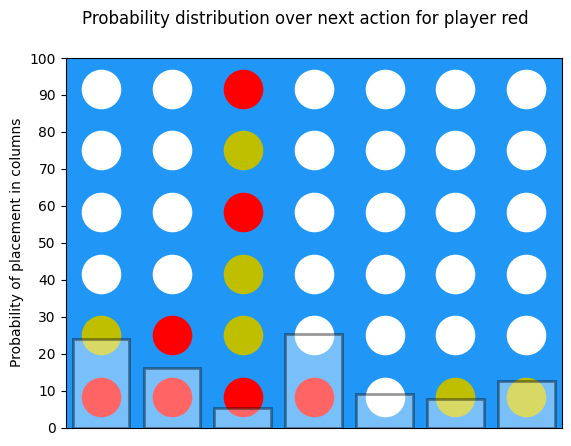

[[0.23827823 0.16127402 0.05409843 0.25363898 0.0909078  0.0767604
  0.12504214]]
[[0.12428965 0.26139918 0.03227434 0.10820989 0.15040855 0.1980149
  0.12540343]]
[[ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [-1.  1. -1.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0. -1. -1.]]


In [278]:
x = bf.steps([s.flatten()], 1, 1101/1000)
z = bf.steps([s.flatten()], -1, 1061/1000)
s, a, d, i = env.step(x[0])
picture_maker.make_prob_overlay(s.astype(int), x[0]) # 0.11676659 0.10735492 0.22579594 0.22034153 0.11116898 0.10928161 0.10929052
print(x)
print(z)
print(s)

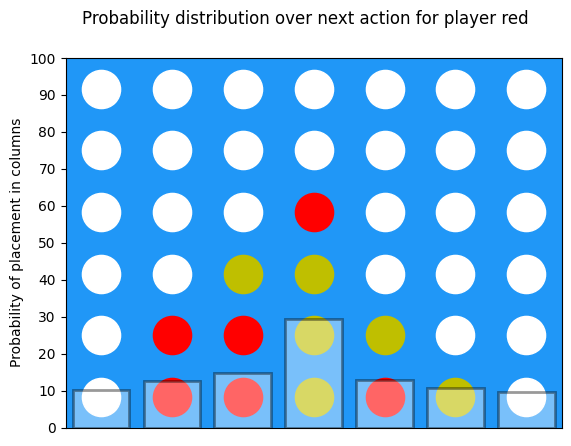

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.]
 [ 0.  1.  1. -1. -1.  0.  0.]
 [ 0.  1.  1. -1.  1. -1.  0.]]


In [100]:
s, a, d, i = env.step([0, 0, 1, 0, 0, 0, 0])
picture_maker.make_prob_overlay(s.astype(int), x[0])
print(s)

In [744]:
s

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1.,  0., -1.,  0.,  1.,  0.],
       [ 1.,  1.,  1., -1.,  1., -1.,  0.]])

In [780]:
# some fun visualizers
# elo
a = env.reset()
for x in range(0, 2000, 100):
    print(x, bf.steps([a], 1, x/1000)[0][3])


0 0.2852396
100 0.29896984
200 0.31292817
300 0.32814944
400 0.34263092
500 0.35605574
600 0.36897996
700 0.38082322
800 0.39279935
900 0.40406778
1000 0.41483378
1100 0.42620927
1200 0.4369834
1300 0.44679278
1400 0.4557999
1500 0.46470174
1600 0.4738076
1700 0.48318848
1800 0.49230918
1900 0.50117314
